Copyright **`(c)`** 2021 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see 'LICENCE.md' for details.

In [32]:
import logging
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from matplotlib import cm
import random

logging.basicConfig(
    format="[%(asctime)s] %(levelname)s: %(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)

In [33]:
def rastrigin(x, A=10):
    """NumPy Rastrigin test function"""
    return -np.sum(A - A * np.cos(2 * np.pi * x) + x**2, axis=0)

def sphere(x):
    return -np.sum(x**2, axis = 0)

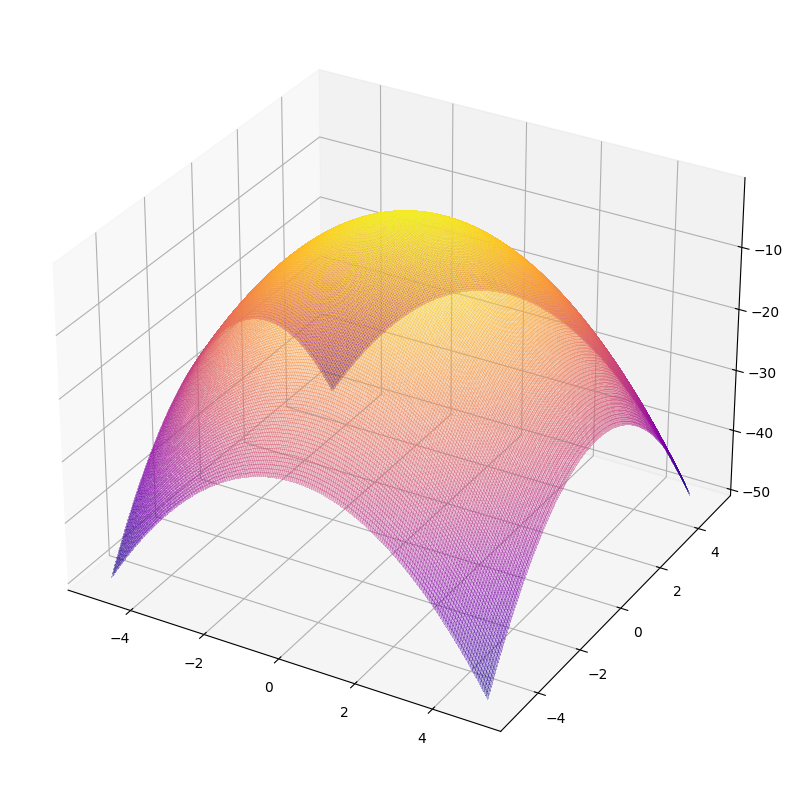

In [34]:
N_POINTS = 200
r = np.linspace(-5, 5, N_POINTS)
x = np.array(np.meshgrid(r, r))
# z = rastrigin(x)
z = sphere(x)
plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.plot_surface(*np.meshgrid(r, r), z, rstride=1, cstride=1, cmap=cm.plasma, alpha= 0.3, linewidth=0, antialiased=False)

In [35]:
np.random.seed(42)
N_DIM = 2

## Evolutionary Strategies

In [44]:
def draw_solutions(solutions, sol, show=False):
    N_POINTS = 200
    r = np.linspace(-5, 5, N_POINTS)
    x = np.array(np.meshgrid(r, r))
    z = rastrigin(x)
    # z = sphere(x)
    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection="3d")
    ax.plot_surface(*np.meshgrid(r, r), z, rstride=1, cstride=1, cmap=cm.plasma, alpha=0.1, linewidth=0, antialiased=False)
    for solution in solutions:
        ax.scatter(solution[0], solution[1], rastrigin(solution), s=10, color='k')
    if show:
        z = np.array([rastrigin(np.array([solutions[i, 0], solutions[i, 1]]))for i in range(solutions.shape[0])])
        print(z.shape)
        print(solutions[:, 0])
        ax.plot(solutions[:, 0], solutions[:, 1], z, color='k')
    ax.scatter(sol[0], sol[1], rastrigin(sol), s=30,alpha=0.1, color='r')
    ax.scatter(0, 0, rastrigin(np.array([0, 0])), s=30,alpha=0.1, color='b')

[14:05:53] DEBUG: Found a new solution [-2.6693395  -4.98335281]
[14:05:53] DEBUG: Found a new solution [-1.76266092 -1.49629092]
[14:05:53] DEBUG: Found a new solution [-0.92766308  3.65312748]
[14:05:53] DEBUG: Found a new solution [ 3.18346448 -0.30471618]
[14:05:53] DEBUG: Found a new solution [-0.98467363  1.11088216]
[14:05:53] DEBUG: Found a new solution [-0.93752857  1.08550576]
[14:05:53] DEBUG: Found a new solution [-0.00121823  0.93824143]
[14:05:53] DEBUG: Found a new solution [0.01079145 1.00959747]
[14:05:54] DEBUG: Found a new solution [-0.0311451   0.01530078]
[14:05:54] DEBUG: Found a new solution [0.00510025 0.02505378]
[14:05:54] DEBUG: Found a new solution [ 0.0149526  -0.01604891]
[14:05:55] DEBUG: Found a new solution [-0.00688161 -0.01244135]
[14:05:56] DEBUG: Result: [-0.00688161 -0.01244135], found in 12 iteration


(13, 2)
Found a solution in [-0.00688161 -0.01244135], d=0.04008674045655916
(13,)
[-5.00000000e+00 -2.66933950e+00 -1.76266092e+00 -9.27663079e-01
  3.18346448e+00 -9.84673629e-01 -9.37528565e-01 -1.21822906e-03
  1.07914479e-02 -3.11450994e-02  5.10025086e-03  1.49526042e-02
 -6.88161347e-03]


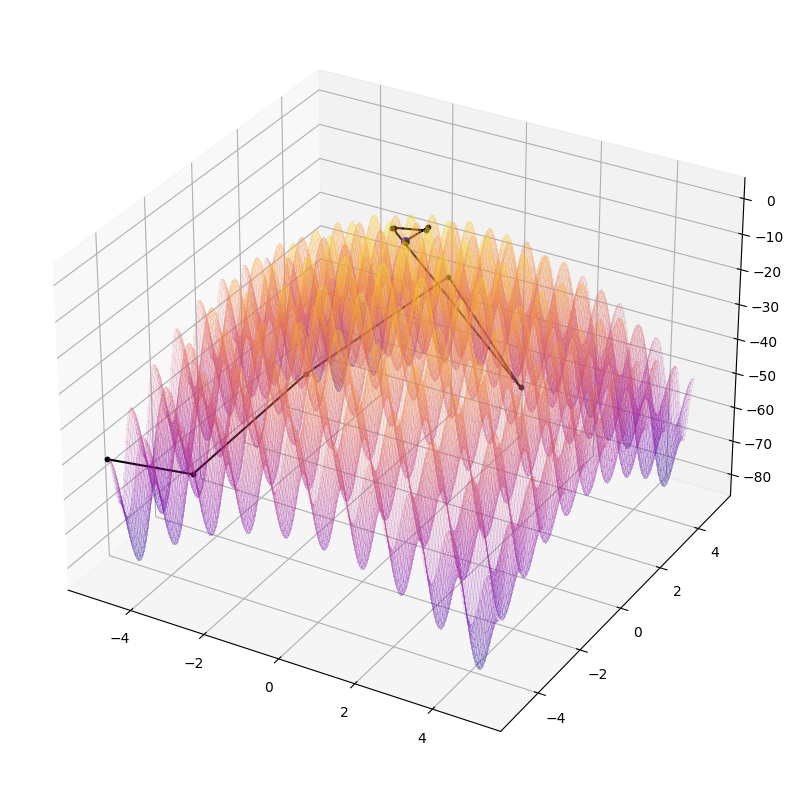

In [45]:
def evaluate(sol):
    return rastrigin(sol)

def solve(mut_rate = 1):
    # Strating from this, mutate until convergence.
    unuseful_step = 0
    sol = np.array([-5, -5])
    solutions = [sol]
    iteration = 0
    while unuseful_step < 100000:
        unuseful_step += 1
        new_sol = np.array([sol[0] + np.random.normal(0, mut_rate), sol[1] + np.random.normal(0, mut_rate)])
        if evaluate(new_sol) > evaluate(sol):
            logging.debug(f"Found a new solution {new_sol}")
            iteration += 1
            sol = new_sol
            solutions.append(sol)
            unuseful_step = 0
        else: 
            unuseful_step += 1
    logging.debug(f"Result: {sol}, found in {iteration} iteration")
    return solutions, sol

logging.getLogger().setLevel(logging.DEBUG)
solutions, sol = solve(3)
solutions = np.array(solutions)
print(solutions.shape)
print(f"Found a solution in {sol}, d={abs(rastrigin(sol) - rastrigin(np.array([0, 0])))}")
draw_solutions(np.array(solutions), sol, show=True)
